In [86]:
# makemore part 3
# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb
# build a character level prediction
# using a multi-layer neural network to predict the next word 
# given the previous ones
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
# page 1142, we build neural network defined in Figure 1

# https://blog.ezyang.com/2019/05/pytorch-internals/
# PyTorch internals blog post, logical construct


In [2]:
!python -V

Python 3.10.15


In [249]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for graph visualization
# magic command to display graph within cells
# !pip install matplotlib ipython
%matplotlib inline  

In [7]:
# https://github.com/karpathy/makemore/blob/master/names.txt
# !cp /Users/user/Downloads/names.txt .

In [8]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [13]:
# check total length
len(words), len(words)//2

(32033, 16016)

In [11]:
min(len(w) for w in words)

2

In [12]:
max(len(w) for w in words)

15

In [26]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)  # total 27 characters 26 + ".", used below in Y

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [45]:
# build the dataset
block_size = 3 # context length: how many characters we take to predict the next one?
X, Y = [], []   # X: input to neural net, Y: labels for each example inside X
for w in words[:5]:
    print(w)
    context = [0] * block_size   # padded context starting with 0 tokens
    for ch in w + '.':
        ix = stoi[ch]
        # print(ch)    # emma, olivia, ava, isabella
        # print(ix)    # 5, 13, 13, 1, 0, ...
        # print(context)  # [0, 0, 0], [0, 0, 5], [0, 5, 13]
        X.append(context)   # current running context
        Y.append(ix)        # Y current character
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        # print(context[1:], [ix])  # [0, 0] [5], [0, 5] [13], [5, 13] [13]
        context = context[1:] + [ix]  # crop and append, rolling window context
                                      # remove context[0], append [ix]
                                      # to keep block_size
        # print(context, [ix])  # [0, 0, 5] [5], [0, 5, 13] [13], [5, 13, 13] [13]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [51]:
X.shape, X.dtype, Y.shape, Y.dtype
# total 32 examples of context, and 32 labels in integer
# objectives: take X input to predict Y

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [52]:
X # individual examples from 5 examples

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [54]:
Y # labels, build neural network, take input of X, predict Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [56]:
len(set(Y))

32

In [59]:
# First build embedding lookup table C
# We have 27 characters, we can start with 2 dimensional space
C = torch.randn((27, 2))    # 27 rows, 2 columns
                            # each 27 characters has a 2 dimensional embeddings
                            # at beginning it is initialized randomly

In [60]:
C

tensor([[ 2.0287e-01, -1.2250e-01],
        [-9.5518e-01, -2.9084e-01],
        [ 6.2059e-01, -1.8404e+00],
        [ 8.7281e-02,  7.6165e-01],
        [ 5.0053e-01, -3.0633e-01],
        [-1.6754e+00, -5.2172e-01],
        [ 2.3319e+00, -3.4363e-01],
        [ 3.3123e-02, -1.1252e+00],
        [ 1.6001e+00,  1.1604e+00],
        [-4.9162e-01,  3.8635e-02],
        [-7.2178e-01,  3.7027e-01],
        [ 1.3269e+00,  7.5952e-04],
        [-9.1578e-01, -1.0278e+00],
        [ 5.7028e-01,  1.0984e+00],
        [-1.4193e+00,  1.4006e+00],
        [-9.7100e-01, -1.0740e+00],
        [ 9.1988e-01, -4.4818e-01],
        [-1.2028e-01,  6.9088e-01],
        [ 4.9088e-01, -4.3562e-01],
        [-9.1984e-01,  6.9254e-01],
        [-9.9569e-01, -2.6228e-01],
        [-3.0904e-01,  4.6989e-01],
        [-8.0374e-01,  1.0420e+00],
        [-8.7421e-01,  3.6362e-01],
        [-4.8800e-01,  1.1134e-01],
        [ 4.1788e-01,  5.0674e-02],
        [ 1.1535e+00,  5.2682e-01]])

In [61]:
C[5]  # 1. Indexing, One way we just take the row 5 for number 5 with current value

tensor([-1.6754, -0.5217])

In [64]:
# We can use hot encoding for 5 in 27 classes
# Every bit is 0, except 5th bit is turned on
# torch.nn.functional as F
# F.one_hot(5, num_classes=27)   # Error, 5 must be Tensor, not int
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [65]:
# The shape is 27
F.one_hot(torch.tensor(5), num_classes=27).shape

torch.Size([27])

In [70]:
# 2. Take one_hot vector multiple by C
# F.one_hot(torch.tensor(5), num_classes=27) @ C  
# RuntimeError: expected scalar type Long but found Float 
print(F.one_hot(torch.tensor(5), num_classes=27).dtype, C.dtype)  # int vs float

torch.int64 torch.float32


In [72]:
# cast one_hot to float and multiply
F.one_hot(torch.tensor(5), num_classes=27).float() @ C
# return exact value as above, because rows with 0 are masking out, except row 5

tensor([-1.6754, -0.5217])

In [73]:
# We used two optioins indexing and one-hot encoding methods
# We will just use indexing because it is faster and easier
# row of index 5
C[5]

tensor([-1.6754, -0.5217])

In [76]:
# We can use index with input of list, as one dimensional tensor of integers
C[[5,6,7,7,7]]

tensor([[-1.6754, -0.5217],
        [ 2.3319, -0.3436],
        [ 0.0331, -1.1252],
        [ 0.0331, -1.1252],
        [ 0.0331, -1.1252]])

In [78]:
# We can also index with 2 dimensional tensor, it just work
# C lookup table, X: 32 examples of context from above
C[X]

tensor([[[ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225]],

        [[ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-1.6754, -0.5217]],

        [[ 0.2029, -0.1225],
         [-1.6754, -0.5217],
         [ 0.5703,  1.0984]],

        [[-1.6754, -0.5217],
         [ 0.5703,  1.0984],
         [ 0.5703,  1.0984]],

        [[ 0.5703,  1.0984],
         [ 0.5703,  1.0984],
         [-0.9552, -0.2908]],

        [[ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225]],

        [[ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-0.9710, -1.0740]],

        [[ 0.2029, -0.1225],
         [-0.9710, -1.0740],
         [-0.9158, -1.0278]],

        [[-0.9710, -1.0740],
         [-0.9158, -1.0278],
         [-0.4916,  0.0386]],

        [[-0.9158, -1.0278],
         [-0.4916,  0.0386],
         [-0.8037,  1.0420]],

        [[-0.4916,  0.0386],
         [-0.8037,  1.0420],
         [-0.4916,  0.0386]],

        [[-0.8037,  1

In [79]:
C[X].shape
# We retrieve 2 dimensional embeddings

torch.Size([32, 3, 2])

In [81]:
# Example index of 13, the 2nd dimension, is tensor(1)
X[13, 2]

tensor(1)

In [82]:
# getting embedding from C
C[X][13,2]

tensor([-0.9552, -0.2908])

In [83]:
# verify C[1] embedding is same as above, they are equal
C[1]

tensor([-0.9552, -0.2908])

In [85]:
# pytorch indexing is awesome, it just works
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [89]:
# Construct hidden layer, we call W1, initialized randomly
# we have 32 examples, 2 dimensional embeddings, we have 3 of them
# 3: block size
# 2: embedding size
# these values are used from the paper cited at the beginning, tanh middle layer

# input to the layer: 6 = 3*2 (2 dimensional * 3 of them)
# number of neurons: 100 (we decided)
W1 = torch.randn((6, 100))
b1 = torch.randn(100)   # 100 bias, we need 100 of them

In [93]:
# emb @ W1 + b1, this is roughly what we want to do 
# this does not because emb is stacked up with [32, 3, 2]
# we need concatenate input together
# we need to transform [32, 3, 2] to [32, 6
# There are many options on https://docs.pytorch.org/docs/stable/torch.html
# lookup torch / concatnenate, and others to create/transform etc operations
emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]  # all rows, 3 context blocks
                                          # we need to concat them


(tensor([[ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-1.6754, -0.5217],
         [ 0.5703,  1.0984],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-0.9710, -1.0740],
         [-0.9158, -1.0278],
         [-0.4916,  0.0386],
         [-0.8037,  1.0420],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-0.9552, -0.2908],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-0.4916,  0.0386],
         [-0.9198,  0.6925],
         [-0.9552, -0.2908],
         [ 0.6206, -1.8404],
         [-1.6754, -0.5217],
         [-0.9158, -1.0278],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-0.9198,  0.6925],
         [-0.9710, -1.0740],
         [ 0.9199, -0.4482],
         [ 1.6001,  1.1604]]),
 tensor([[ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-1

In [98]:
emb[:, 0, :].shape # the first word

torch.Size([32, 2])

In [99]:
emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]  
#, 0th, first, 2nd dimensions, per paper input line
# we need to concat to 6 dimensions in order to multiply with C

(tensor([[ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-1.6754, -0.5217],
         [ 0.5703,  1.0984],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-0.9710, -1.0740],
         [-0.9158, -1.0278],
         [-0.4916,  0.0386],
         [-0.8037,  1.0420],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-0.9552, -0.2908],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-0.4916,  0.0386],
         [-0.9198,  0.6925],
         [-0.9552, -0.2908],
         [ 0.6206, -1.8404],
         [-1.6754, -0.5217],
         [-0.9158, -1.0278],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-0.9198,  0.6925],
         [-0.9710, -1.0740],
         [ 0.9199, -0.4482],
         [ 1.6001,  1.1604]]),
 tensor([[ 0.2029, -0.1225],
         [ 0.2029, -0.1225],
         [-1

In [104]:
# treat above as sequence, concat along dimension 1, 
# when concat along dimension 0, it produces 32 * 3 = 96 rows
# try it out with dim=0
# cat option 1
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)

tensor([[ 0.2029, -0.1225,  0.2029, -0.1225,  0.2029, -0.1225],
        [ 0.2029, -0.1225,  0.2029, -0.1225, -1.6754, -0.5217],
        [ 0.2029, -0.1225, -1.6754, -0.5217,  0.5703,  1.0984],
        [-1.6754, -0.5217,  0.5703,  1.0984,  0.5703,  1.0984],
        [ 0.5703,  1.0984,  0.5703,  1.0984, -0.9552, -0.2908],
        [ 0.2029, -0.1225,  0.2029, -0.1225,  0.2029, -0.1225],
        [ 0.2029, -0.1225,  0.2029, -0.1225, -0.9710, -1.0740],
        [ 0.2029, -0.1225, -0.9710, -1.0740, -0.9158, -1.0278],
        [-0.9710, -1.0740, -0.9158, -1.0278, -0.4916,  0.0386],
        [-0.9158, -1.0278, -0.4916,  0.0386, -0.8037,  1.0420],
        [-0.4916,  0.0386, -0.8037,  1.0420, -0.4916,  0.0386],
        [-0.8037,  1.0420, -0.4916,  0.0386, -0.9552, -0.2908],
        [ 0.2029, -0.1225,  0.2029, -0.1225,  0.2029, -0.1225],
        [ 0.2029, -0.1225,  0.2029, -0.1225, -0.9552, -0.2908],
        [ 0.2029, -0.1225, -0.9552, -0.2908, -0.8037,  1.0420],
        [-0.9552, -0.2908, -0.8037,  1.0

In [105]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape
# now [32, 6] is the size what we want 
# however, torch.cat is not flexible, what if we use input of 5 block size?

torch.Size([32, 6])

In [109]:
# concat option 2: use torch.unbind, without hardcoded value
# works the same as concat option 1, but works for any block size
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
# note: torch.cat create new memory storage, very not efficient
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape
# torch.Size([32, 6])

tensor([[ 0.2029, -0.1225,  0.2029, -0.1225,  0.2029, -0.1225],
        [ 0.2029, -0.1225,  0.2029, -0.1225, -1.6754, -0.5217],
        [ 0.2029, -0.1225, -1.6754, -0.5217,  0.5703,  1.0984],
        [-1.6754, -0.5217,  0.5703,  1.0984,  0.5703,  1.0984],
        [ 0.5703,  1.0984,  0.5703,  1.0984, -0.9552, -0.2908],
        [ 0.2029, -0.1225,  0.2029, -0.1225,  0.2029, -0.1225],
        [ 0.2029, -0.1225,  0.2029, -0.1225, -0.9710, -1.0740],
        [ 0.2029, -0.1225, -0.9710, -1.0740, -0.9158, -1.0278],
        [-0.9710, -1.0740, -0.9158, -1.0278, -0.4916,  0.0386],
        [-0.9158, -1.0278, -0.4916,  0.0386, -0.8037,  1.0420],
        [-0.4916,  0.0386, -0.8037,  1.0420, -0.4916,  0.0386],
        [-0.8037,  1.0420, -0.4916,  0.0386, -0.9552, -0.2908],
        [ 0.2029, -0.1225,  0.2029, -0.1225,  0.2029, -0.1225],
        [ 0.2029, -0.1225,  0.2029, -0.1225, -0.9552, -0.2908],
        [ 0.2029, -0.1225, -0.9552, -0.2908, -0.8037,  1.0420],
        [-0.9552, -0.2908, -0.8037,  1.0

In [121]:
# concat option 3: a significant better way for concat
# also can hint some of the internals of torch.tensor
# here is an example
a = torch.arange(18)  # 
# a
# tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
print(a.shape)
print(a.view(2, 9))  # 2 by 9 tensor
print(a.view(9, 2))  # or 9 by 2 tensor
print(a.view(3, 3, 2))   # or 3 by 3 by 2 tensor
# as long as total number multiply together is the same as length

# tensor .view() if very efficient, each tensor has a storage
# the storage is always one dimensional vector
# this is how the tensor is represented in the computer memory
# no memory is being changed copied moved created when we call view()
# this is from tensor storage offset, strides, and shapes
# so the bytes is seen as dimensional arrays
print(a.storage())

torch.Size([18])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])
tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 18]


In [125]:
# check embedding size
print(emb.shape)

# we can use view() to treate it as (32, 6)
print(emb.view(32, 6))

# verify the results are same when using view and cat
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

torch.Size([32, 3, 2])
tensor([[ 0.2029, -0.1225,  0.2029, -0.1225,  0.2029, -0.1225],
        [ 0.2029, -0.1225,  0.2029, -0.1225, -1.6754, -0.5217],
        [ 0.2029, -0.1225, -1.6754, -0.5217,  0.5703,  1.0984],
        [-1.6754, -0.5217,  0.5703,  1.0984,  0.5703,  1.0984],
        [ 0.5703,  1.0984,  0.5703,  1.0984, -0.9552, -0.2908],
        [ 0.2029, -0.1225,  0.2029, -0.1225,  0.2029, -0.1225],
        [ 0.2029, -0.1225,  0.2029, -0.1225, -0.9710, -1.0740],
        [ 0.2029, -0.1225, -0.9710, -1.0740, -0.9158, -1.0278],
        [-0.9710, -1.0740, -0.9158, -1.0278, -0.4916,  0.0386],
        [-0.9158, -1.0278, -0.4916,  0.0386, -0.8037,  1.0420],
        [-0.4916,  0.0386, -0.8037,  1.0420, -0.4916,  0.0386],
        [-0.8037,  1.0420, -0.4916,  0.0386, -0.9552, -0.2908],
        [ 0.2029, -0.1225,  0.2029, -0.1225,  0.2029, -0.1225],
        [ 0.2029, -0.1225,  0.2029, -0.1225, -0.9552, -0.2908],
        [ 0.2029, -0.1225, -0.9552, -0.2908, -0.8037,  1.0420],
        [-0.9552,

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [126]:
# back to the hidden state layer
emb.view(32, 6) @ W1 + b1#

tensor([[-0.9741,  1.3453, -1.1308,  ..., -0.0494, -0.7475,  1.2418],
        [ 2.3121,  3.4003, -0.1486,  ..., -2.5865,  0.7108, -1.7986],
        [-3.1275,  4.1361, -3.4647,  ..., -1.3200, -7.2806,  6.6168],
        ...,
        [-1.6972,  0.2364,  0.1735,  ..., -0.6546, -1.6246,  5.7556],
        [ 0.7710,  0.0356, -1.2326,  ..., -0.9700,  2.3954, -4.2220],
        [-0.8593,  3.2701, -4.5040,  ..., -0.1740, -1.6253, -3.1455]])

In [127]:
# assign to hidden layer, we get 
h = emb.view(32, 6) @ W1 + b1
h.shape
# for every one of 32 examples, we have 100 dimensional activations neurons

torch.Size([32, 100])

In [130]:
# refactor without using harded value
# h = emb.view(emb.shape[0], 6) @ W1 + b1  # we use value from shape
h = emb.view(-1, 6) @ W1 + b1   # use -1 so pytorch will infer the value
                                # because number of elemnents must be same
                                # (x) * 6 = (x) * 3 * 2, x = 32, 
                                # pytorch derive x must be 32
h

tensor([[-0.9741,  1.3453, -1.1308,  ..., -0.0494, -0.7475,  1.2418],
        [ 2.3121,  3.4003, -0.1486,  ..., -2.5865,  0.7108, -1.7986],
        [-3.1275,  4.1361, -3.4647,  ..., -1.3200, -7.2806,  6.6168],
        ...,
        [-1.6972,  0.2364,  0.1735,  ..., -0.6546, -1.6246,  5.7556],
        [ 0.7710,  0.0356, -1.2326,  ..., -0.9700,  2.3954, -4.2220],
        [-0.8593,  3.2701, -4.5040,  ..., -0.1740, -1.6253, -3.1455]])

In [131]:
# to calculate h, we use tanh to get values between -1 and 1
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.7505,  0.8729, -0.8113,  ..., -0.0493, -0.6337,  0.8460],
        [ 0.9806,  0.9978, -0.1475,  ..., -0.9887,  0.6112, -0.9467],
        [-0.9962,  0.9995, -0.9980,  ..., -0.8668, -1.0000,  1.0000],
        ...,
        [-0.9351,  0.2320,  0.1718,  ..., -0.5747, -0.9253,  1.0000],
        [ 0.6475,  0.0356, -0.8433,  ..., -0.7487,  0.9835, -0.9996],
        [-0.6959,  0.9971, -0.9998,  ..., -0.1723, -0.9254, -0.9963]])

In [133]:
print(h.shape) 
# this is the hidden layer of activation
# for every of 32 examples

torch.Size([32, 100])


In [134]:
# here is what we do with "+ b1", the broadcast operation
(emb.view(-1, 6) @ W1).shape

torch.Size([32, 100])

In [135]:
b1.shape

torch.Size([100])

In [136]:
# the addition will broadcast these 2
# 32, 100   # broadcast to 100
#  1, 100   # create a fake 1 by 100 row vector
# copy over using broadcast addition for b1, bias
# h = emb.view(32, 6) @ W1 + b1

In [137]:
# finally, we create final layer
W2 = torch.randn(100, 27)   # we have 27 possible characters coming next
b2 = torch.randn(27)        # bias also set to 27


In [141]:
logits = h @ W2 + b2

# why logits?
# The expression logits = h @ W2 + b2 is commonly seen in the final layer
# of a neural network during machine learning training, 
# particularly in classification tasks.
# Logits can range from negative infinity to positive infinity. 
# In multi-class classification, these are typically 
# transformed into probabilities using the softmax function.

# logits
# the vector of raw (non-normalized) predictions that a classification model 
# generates, which is ordinarily then passed to a normalization function. 
# If the model is solving a multi-class classification problem, 
# logits typically become an input to the softmax function. 
# The softmax function then generates a vector of (normalized) probabilities 
# with one value for each possible class.

# TensorFlow domain, logits are the values to be used as input to softmax.

# Logits Layer
# The final layer in our neural network is the logits layer, which will return 
# the raw values for our predictions. We create a dense layer with 10 neurons 
# (one for each target class 0–9), with linear activation (the default):
# logits = tf.layers.dense(inputs=dropout, units=10)
                                                                                                                                                          

In [139]:
logits.shape

torch.Size([32, 27])

In [144]:
# check first 2 output
logits[:2]

tensor([[  1.0269,  -3.6410,  -5.6520,  -2.4104,  -5.3931,   1.2725,  -0.9454,
          -0.5645,  -0.1680,   0.0649,  -8.1588,   1.4206,  -9.1427,  16.8950,
          -1.4107,  -0.5246,  -0.6414,   5.5480,   1.5278,  -4.8833,  -7.1160,
           1.9735,  -8.8703,   6.0734,   0.4924,  11.7541, -12.6617],
        [  1.6705,  -0.6675,  -3.7654,  -6.1269,  -1.2130,  -2.7828,  -2.4969,
          -1.5790,  20.3307,  -9.9632,   0.0625,   4.4554,  -4.2708,  14.2083,
           1.9571,   1.4406,  -1.4997,   3.3357,   6.7425,  -3.5676,  -7.2011,
          -3.5109,  -6.7805,  -1.3008,  -8.3231,  -3.0975,  -3.6173]])

In [145]:
# first we take logits, and exponentiate them to get fake counts
# then normalize them into  aprobability
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)   # 1 first dimension

In [149]:
print(prob.shape)      # shape matches
print(prob[0].sum())   # sum of each row = 1, so it is normalized

torch.Size([32, 27])
tensor(1.0000)


In [150]:
# now we use Y labels to match probability
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [152]:
# we can index the prob the following way
# for each of 32 rows, we grab from Y column
# this is the current prob assigned by this neural network
# however, we have not trained neural network yet
# idealy the results should be 1, when we perfect predict the characters
prob[torch.arange(32), Y]  

tensor([1.6318e-07, 2.1884e-03, 1.5879e-02, 9.6665e-01, 1.6983e-11, 2.7052e-08,
        2.8058e-09, 9.6034e-08, 1.5731e-11, 1.8516e-08, 4.3194e-11, 7.9973e-10,
        1.1988e-09, 1.4541e-11, 1.1189e-15, 6.7349e-07, 4.8777e-08, 1.9313e-11,
        1.4140e-15, 9.0826e-05, 2.3189e-08, 6.7347e-05, 1.6816e-08, 6.6465e-07,
        2.1120e-06, 3.4615e-10, 1.1462e-09, 5.5332e-10, 1.4726e-09, 5.7844e-06,
        7.1978e-08, 8.2742e-07])

In [165]:
# we also want to look at the log probability log()
# and the average of probability
# and negative it -1, to create loss function

loss = -prob[torch.arange(32), Y].log().mean()
loss    # we want to minimize it, to allow network to predict the correct 
        # the next character in the sequence

# why use log()?
# In maximum likelihood estimation, the goal is to maximize the likelihood 
# of observing the true labels given the model's predictions. 
# Maximizing the product of probabilities is equivalent to maximizing 
# the sum of their logarithms (since log(a*b) = log(a) + log(b)). 
# Summing is computationally more stable and easier to work with 
# than multiplying many small probabilities.

# why use negative sign -
# The negative sign - before log() converts the log-likelihood into a 
# loss function. When training a model, the objective is to minimize the loss. 
# Minimizing the negative log-likelihood is equivalent to maximizing 
# the log-likelihood (and thus the likelihood).

# Minimizing the Negative Log Likelihood (NLL)


tensor(17.7758)

In [157]:
# Below is re-write above code to make it respectable
X.shape, Y.shape  # this is the dataset

(torch.Size([32, 3]), torch.Size([32]))

In [159]:
g = torch.Generator().manual_seed(42)   # for reproducibility
C = torch.randn((27, 2), generator=g)   # indexing lookup table
W1 = torch.randn((6, 100), generator=g)  # hidden layer
b1 = torch.randn(100, generator=g)       # hidden layer bias 
W2 = torch.randn((100, 27), generator=g)  # final layer
b2 = torch.randn(27, generator=g)         # final layer bias
parameters = [C, W1, b1, W2, b2]          # cluster all together to count paramters

print(sum(p.nelement() for p in parameters))  # number of parameters in total

3481


In [189]:
# forward path we devloped above
emb = C[X]  # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2   # (32, 27)
counts = logits.exp()

# below block is not efficient to run, create new tensors in memory
# backward pass is complicted mathematically
##
prob = counts / counts.sum(1, keepdims=True)
# loss = prob[torch.arange(32), Y].log().shape   # torch.Size([32]) 
# loss = prob[torch.arange(32), Y].log().mean()     # tensor(-17.7758)
loss = -prob[torch.arange(32), Y].log().mean()
##

loss   # the single number of loss
# take logits to calculate loss for classification problem

tensor(17.7758)

In [190]:
# pytorch has a better efficient way of using cross entropy just for this
# which has the same result
# many reasons of using pytorch cross_entropy, rather above self implementations
# run in less kernel, less memory, numerically well behaved
# 1 forward pass efficient
# 2 backward pass efficient
# 3 numerically well behaved
F.cross_entropy(logits, Y)

tensor(17.7758)

In [191]:
# an example of cross_entropy() which numerically well behaved
logits = torch.tensor([-5, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs  # all goods

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

In [192]:
logits = torch.tensor([-5, -3, 0, 100])
counts = logits.exp()
counts   # not good, logits.exp(100) overflow, 
# tensor([0.0067, 0.0498, 1.0000,    inf])

tensor([0.0067, 0.0498, 1.0000,    inf])

In [193]:
# what pytorch does internally, -100
logits = torch.tensor([-5, -3, 0, 100]) - 100
counts = logits.exp()
counts   # no 'inf'

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [196]:
# now we setup the training of this neural net
for p in parameters:
    p.requires_grad = True  # enable gradient

# for _ in range(10):  # epochs
for _ in range(1000):  # epochs
    # forward pass
    emb = C[X]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100) 
    logits = h @ W2 + b2  # 32, 27)
    loss = F.cross_entropy(logits, Y)
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None   # same as setting to zero in pytorch, disable it
                        # so backward path not add new values
                        # backward will uses current values already created in forward path
    loss.backward()     # populate backward to populate gradients
    # update
    for p in parameters:
        p.data += -0.1 * p.grad   # -0.1 learning rate 
                                  # can change to -0.01 and other values
# we see loss value descreasing
print(loss.item())   # after 1000 iterations, we get very very low loss
                    # we make very good predictions
                    # overfitting here!!
                    # why? we only overfitting 32 examples from first 5 words
                    # very easy to make these 32 examples fit with 
                    # total parameters = [C, W1, b1, W2, b2]  = 3481 
                    # so many parameters for so few examples


0.25287145376205444


In [197]:
# we will not be able to reach loss of 0
# the logits and Y have some differences
# indices (19, 13, 13, ...)    # predicted
# Y ([5, 13, 13, ...])    # actual
# now we need to normalize the dataset to fix overfitting
logits.max(1)

torch.return_types.max(
values=tensor([11.1833, 15.2753, 14.0977, 15.6754, 22.3369, 11.1833, 15.8866, 20.9870,
        13.8914, 15.7653, 12.3266, 21.6826, 11.1833, 17.6400, 14.2953, 18.8668,
        11.1833, 12.5343, 14.5744, 16.9000, 16.9572, 16.8277, 19.4549, 16.8904,
        19.0334, 11.1833, 13.6770, 14.0749, 14.7409, 18.1967, 13.9223, 23.1386],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [198]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [199]:
# fix overfitting issue due to limited examples in dataset 
# repeat dataset code to load all words
block_size = 3
X, Y = [],[]
for w in words:   # !!! use all words, not just 5
    context = [0] * block_size 
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # sliding window
X = torch.tensor(X)
Y = torch.tensor(Y)

In [200]:
# repeat code
g = torch.Generator().manual_seed(42)   # for reproducibility
C = torch.randn((27, 2), generator=g)   # indexing lookup table
W1 = torch.randn((6, 100), generator=g)  # hidden layer
b1 = torch.randn(100, generator=g)       # hidden layer bias 
W2 = torch.randn((100, 27), generator=g)  # final layer
b2 = torch.randn(27, generator=g)         # final layer bias
parameters = [C, W1, b1, W2, b2]          # cluster all together to count paramters

print(sum(p.nelement() for p in parameters))  # number of parameters in total

3481


In [201]:
# repeat code
# now we setup the training of this neural net
for p in parameters:
    p.requires_grad = True  # enable gradient

# for _ in range(10):  # epochs
for _ in range(1000):  # epochs
    # forward pass
    emb = C[X]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100) 
    logits = h @ W2 + b2  # 32, 27)
    loss = F.cross_entropy(logits, Y)
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None   # same as setting to zero in pytorch, disable it
                        # so backward path not add new values
                        # backward will uses current values already created in forward path
    loss.backward()     # populate backward to populate gradients
    # update
    for p in parameters:
        p.data += -0.1 * p.grad   # -0.1 learning rate 
                                  # can change to -0.01 and other values
# we see loss value descreasing
print(loss.item()) 

# !!! this training process takes too much time, overload too much work with all examples
# because it takes forward, backward, and update for all examples of 228146
# the above calculation took 5+ minutes about

2.5217928886413574


In [202]:
# let's address this problem
# in general, forward, backward, and update on mini-batched data from dataset randomly selected
torch.randint(0, 5, (32,))   # random numbers between 0 to 5, 32 of them


tensor([1, 0, 2, 1, 2, 1, 0, 2, 0, 2, 4, 0, 2, 2, 0, 0, 4, 2, 0, 3, 1, 1, 4, 1,
        3, 1, 0, 3, 2, 0, 2, 4])

In [206]:
# but we want to use the input size
# X.shape 
# torch.Size([228146, 3])
# mini-batch size is 32
torch.randint(0, X.shape[0], (32,))

tensor([193405, 166759,  32970, 225440, 109893,  83194,  56437,  71602,  86802,
        128775,  15768,  14613, 109109,  23244, 181964,  39587,  17776, 144912,
        153663, 160664, 126313,  81922,  86786, 192124,  92246, 105630, 119957,
        215429, 163105,  31018, 151536,  64807])

In [204]:
X.shape

torch.Size([228146, 3])

In [232]:
# repeat code with mini-batch
for p in parameters:
    p.requires_grad = True  # enable gradient
    
for _ in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass 
    emb = C[X[ix]]  # !! changed, only randomly selected rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2   # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])   # !! changed
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
# running is very fast now
# however, the quality of gradient is lower, but it is good enough
# we can use approximate gradients with more steps, rather exact gradient with fewer steps
print(loss.item())

2.376688003540039


In [228]:
# repeat dataset code to load all words again to find reasonable learning rate
# first testing between small values (-0.0001) to exploding values (1, 10)
# then use torch.linspace(0.001, 1, 1000)  # between 0.001 to 1, with 1000 steps
block_size = 3
X, Y = [],[]
for w in words:   # !!! use all words, not just 5
    context = [0] * block_size 
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # sliding window
X = torch.tensor(X)
Y = torch.tensor(Y)

In [229]:
# repeat code
g = torch.Generator().manual_seed(42)   # for reproducibility
C = torch.randn((27, 2), generator=g)   # indexing lookup table
W1 = torch.randn((6, 100), generator=g)  # hidden layer
b1 = torch.randn(100, generator=g)       # hidden layer bias 
W2 = torch.randn((100, 27), generator=g)  # final layer
b2 = torch.randn(27, generator=g)         # final layer bias
parameters = [C, W1, b1, W2, b2]          # cluster all together to count paramters

print(sum(p.nelement() for p in parameters))  # number of parameters in total

3481


In [235]:
# repeat code with mini-batch
for p in parameters:
    p.requires_grad = True  # enable gradient
    
for _ in range(10):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass 
    emb = C[X[ix]]  # !! changed, only randomly selected rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2   # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])   # !! changed
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

2.590359687805176
2.5447566509246826
2.848264217376709
2.910956621170044
2.820953845977783
2.743636131286621
2.5365376472473145
2.5287351608276367
2.639866828918457
2.5137336254119873


In [237]:
# find random range values between minimum and max range, but we do not want this linear output
torch.linspace(0.001, 1, 100)

tensor([0.0010, 0.0111, 0.0212, 0.0313, 0.0414, 0.0515, 0.0615, 0.0716, 0.0817,
        0.0918, 0.1019, 0.1120, 0.1221, 0.1322, 0.1423, 0.1524, 0.1625, 0.1725,
        0.1826, 0.1927, 0.2028, 0.2129, 0.2230, 0.2331, 0.2432, 0.2533, 0.2634,
        0.2735, 0.2835, 0.2936, 0.3037, 0.3138, 0.3239, 0.3340, 0.3441, 0.3542,
        0.3643, 0.3744, 0.3845, 0.3945, 0.4046, 0.4147, 0.4248, 0.4349, 0.4450,
        0.4551, 0.4652, 0.4753, 0.4854, 0.4955, 0.5055, 0.5156, 0.5257, 0.5358,
        0.5459, 0.5560, 0.5661, 0.5762, 0.5863, 0.5964, 0.6065, 0.6165, 0.6266,
        0.6367, 0.6468, 0.6569, 0.6670, 0.6771, 0.6872, 0.6973, 0.7074, 0.7175,
        0.7275, 0.7376, 0.7477, 0.7578, 0.7679, 0.7780, 0.7881, 0.7982, 0.8083,
        0.8184, 0.8285, 0.8385, 0.8486, 0.8587, 0.8688, 0.8789, 0.8890, 0.8991,
        0.9092, 0.9193, 0.9294, 0.9395, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])

In [273]:
# generate learning rate exponent values to analyze learning rate statistics
lre = torch.linspace(-3, 0, 100)   # learning rate exponent, = (0.001, 1, 100) , 10^0 == 1
                                    # space in the interval evenly
lrs = 10**lre     # learning rates we are searching for
lrs               # candidate learning rates

tensor([0.0010, 0.0011, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017,
        0.0019, 0.0020, 0.0022, 0.0023, 0.0025, 0.0027, 0.0028, 0.0031, 0.0033,
        0.0035, 0.0038, 0.0040, 0.0043, 0.0046, 0.0050, 0.0053, 0.0057, 0.0061,
        0.0066, 0.0071, 0.0076, 0.0081, 0.0087, 0.0093, 0.0100, 0.0107, 0.0115,
        0.0123, 0.0132, 0.0142, 0.0152, 0.0163, 0.0175, 0.0187, 0.0201, 0.0215,
        0.0231, 0.0248, 0.0266, 0.0285, 0.0305, 0.0327, 0.0351, 0.0376, 0.0404,
        0.0433, 0.0464, 0.0498, 0.0534, 0.0572, 0.0614, 0.0658, 0.0705, 0.0756,
        0.0811, 0.0870, 0.0933, 0.1000, 0.1072, 0.1150, 0.1233, 0.1322, 0.1417,
        0.1520, 0.1630, 0.1748, 0.1874, 0.2009, 0.2154, 0.2310, 0.2477, 0.2656,
        0.2848, 0.3054, 0.3275, 0.3511, 0.3765, 0.4037, 0.4329, 0.4642, 0.4977,
        0.5337, 0.5722, 0.6136, 0.6579, 0.7055, 0.7565, 0.8111, 0.8697, 0.9326,
        1.0000])

In [276]:
# Train again to find the reasonable learning rate lrs
# repeat code with mini-batch

# repeat dataset code to load all words again to find reasonable learning rate
# first testing between small values (-0.0001) to exploding values (1, 10)
# then use torch.linspace(0.001, 1, 1000)  # between 0.001 to 1, with 1000 steps
block_size = 3
X, Y = [],[]
for w in words:   # !!! use all words, not just 5
    context = [0] * block_size 
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # sliding window
X = torch.tensor(X)
Y = torch.tensor(Y)

# repeat code
g = torch.Generator().manual_seed(42)   # for reproducibility
C = torch.randn((27, 2), generator=g)   # indexing lookup table
W1 = torch.randn((6, 100), generator=g)  # hidden layer
b1 = torch.randn(100, generator=g)       # hidden layer bias 
W2 = torch.randn((100, 27), generator=g)  # final layer
b2 = torch.randn(27, generator=g)         # final layer bias
parameters = [C, W1, b1, W2, b2]          # cluster all together to count paramters

print(sum(p.nelement() for p in parameters))  # number of parameters in total

# repeat code
lre = torch.linspace(-3, 0, 1000)   # learning rate exponent, = (0.001, 1, 100) , 10^0 == 1
                                    # space in the interval evenly
lrs = 10**lre     # learning rates we are searching for
# lrs             # we replace hard coded learning rate 0.1 

for p in parameters:
    p.requires_grad = True  # enable gradient

# tracking learning results
lri = []
lossi = []

for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass 
    emb = C[X[ix]]  # !! changed, only randomly selected rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2   # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])   # !! changed
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad   # the p.grad from forward pass, p: tensors

    # track stats
    # lri.append(lr)    # not learning rate, but lre
    lri.append(lre[i])
    lossi.append(loss.item())
print(loss.item())

3481
7.243827819824219


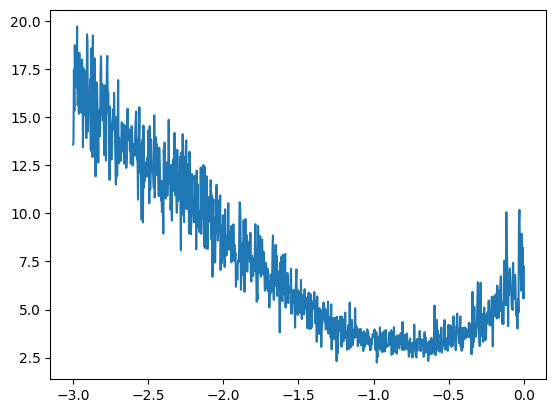

In [277]:
# with lri and lossi, we can do plot
# the lr is from lowest value (0.001) to maximum value (1) during 1000
# left size lr way too low, -1.0 is fairly good lr
plt.plot(lri, lossi)   # x: lr, y: loss
plt.show()  

In [286]:
# Train again with lr of -0.1, now we have some confidence from the graph
# Train again to find the reasonable learning rate lrs
# repeat code with mini-batch

# repeat dataset code to load all words again to find reasonable learning rate
# first testing between small values (-0.0001) to exploding values (1, 10)
# then use torch.linspace(0.001, 1, 1000)  # between 0.001 to 1, with 1000 steps
block_size = 3
X, Y = [],[]
for w in words:   # !!! use all words, not just 5
    context = [0] * block_size 
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # sliding window
X = torch.tensor(X)
Y = torch.tensor(Y)

# repeat code
g = torch.Generator().manual_seed(42)   # for reproducibility
C = torch.randn((27, 2), generator=g)   # indexing lookup table
W1 = torch.randn((6, 100), generator=g)  # hidden layer
b1 = torch.randn(100, generator=g)       # hidden layer bias 
W2 = torch.randn((100, 27), generator=g)  # final layer
b2 = torch.randn(27, generator=g)         # final layer bias
parameters = [C, W1, b1, W2, b2]          # cluster all together to count paramters

# print(sum(p.nelement() for p in parameters))  # number of parameters in total

# repeat code
lre = torch.linspace(-3, 0, 10000)   # !! changed, run long time
# lre = torch.linspace(-3, 0, 1000)   # learning rate exponent, = (0.001, 1, 100) , 10^0 == 1
                                    # space in the interval evenly
lrs = 10**lre     # learning rates we are searching for
# lrs             # we replace hard coded learning rate 0.1 

for p in parameters:
    p.requires_grad = True  # enable gradient

# tracking learning results
lri = []
lossi = []


In [294]:
# run twice with lr = 0.1, loss = 2.5338966846466064, 2.3525137901306152, 
# run twice with lr = 0.01
for i in range(10000):   # run twice with lr = 0.1
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass 
    emb = C[X[ix]]  # !! changed, only randomly selected rows
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2   # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])   # !! changed
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = 0.1  # or 10**-1  , train twice first for 10000
    lr = 0.01  # or 10**-1  , train last ending stage once with smaller lr , improve by using learning rate decay, a factor of 10
    
    for p in parameters:
        p.data += -lr * p.grad   # the p.grad from forward pass, p: tensors

    # track stats
    # lri.append(lr)    # not learning rate, but lre
    # lri.append(lre[i])
    # lossi.append(loss.item())
print(loss.item())

1.9787638187408447


In [295]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2933, grad_fn=<NllLossBackward0>)

In [296]:
# something we need to be careful
# as the capacity of parameters grow, the loss on training set is very very low, could be 0
# but this may be an issue of overfitting, model is memorizing the training dataset
# you will get most from samples from training set
# loss on new sample data can be very high

# a practice is to split the dataset to 
# training split, to train parameters
# dev or validation split, to train hyper parameters
# test split, evaluate the model performance , only allow to use test split a few times to avoid being learning

In [297]:
# let's do data split and use test split very very sparingly

# repeat dataset code to load all words again to find reasonable learning rate
# first testing between small values (-0.0001) to exploding values (1, 10)
# then use torch.linspace(0.001, 1, 1000)  # between 0.001 to 1, with 1000 steps
block_size = 3
X, Y = [],[]
for w in words:   # !!! use all words, not just 5
    context = [0] * block_size 
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # sliding window
X = torch.tensor(X)
Y = torch.tensor(Y)


In [310]:
# convert dataset to a function

def build_dataset(words):
    block_size = 3
    X, Y = [],[]
    for w in words:   # !!! use all words, not just 5
        context = [0] * block_size 
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # sliding window
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)    # shuffle words 
n1 = int(0.8*len(words))  # 80%
n2 = int(0.9*len(words))  # 90%
Xtr, Ytr = build_dataset(words[:n1])   # indexing up to n1
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [311]:
print(len(words))
print(n1)
print(n2)
print(n2 - n1)

32033
25626
28829
3203


In [312]:
# training data from split
Xtr.shape, Ytr.shape

(torch.Size([182437, 3]), torch.Size([182437]))

In [313]:
# reset network
# repeat code
g = torch.Generator().manual_seed(42)   # for reproducibility
C = torch.randn((27, 2), generator=g)   # indexing lookup table
W1 = torch.randn((6, 100), generator=g)  # hidden layer
b1 = torch.randn(100, generator=g)       # hidden layer bias 
W2 = torch.randn((100, 27), generator=g)  # final layer
b2 = torch.randn(27, generator=g)         # final layer bias
parameters = [C, W1, b1, W2, b2]          # cluster all together to count paramters

In [314]:
# only Xtrain

for p in parameters:
    p.requires_grad = True  # enable gradient
    
for i in range(10000):   # run twice with lr = 0.1
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  # !! changed 

    # forward pass 
    emb = C[Xtr[ix]]  # !! changed
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2   # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])   # !! changed
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1  # or 10**-1  , train twice first for 10000
    # lr = 0.01  # or 10**-1  , train last ending stage once with smaller lr , improve by using learning rate decay, a factor of 10
    
    for p in parameters:
        p.data += -lr * p.grad   # the p.grad from forward pass, p: tensors

    # track stats
    # lri.append(lr)    # not learning rate, but lre
    # lri.append(lre[i])
    # lossi.append(loss.item())
print(loss.item())


2.2514100074768066


In [315]:
# evaluate with dev set, neural network did not see Xdev samples during training
emb = C[Xdev] # (32, 3, 2)   # !! changed
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)   #!! changed
loss

tensor(2.4664, grad_fn=<NllLossBackward0>)

In [318]:
# checking training set loss, about equal, may indicates not overfitting
# the model is not powerful enough to memorize the data
emb = C[Xtr] # (32, 3, 2)   # !! changed
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)   #!! changed
loss

tensor(2.4543, grad_fn=<NllLossBackward0>)

In [323]:
# a new issue of underfitting, because of the small amount of data
# we need to scale up the neural net
# train network again to with scaled up neurons and parameters 

# repeat code
g = torch.Generator().manual_seed(42)   # for reproducibility
C = torch.randn((27, 2), generator=g)   # indexing lookup table
W1 = torch.randn((6, 300), generator=g)  # hidden layer, !! changed 100 to 300
b1 = torch.randn(300, generator=g)       # hidden layer bias  !! also changed from 100 to 300
W2 = torch.randn((300, 27), generator=g)  # final layer  !! changed 
b2 = torch.randn(27, generator=g)         # final layer bias
parameters = [C, W1, b1, W2, b2]          # cluster all together to count paramters

print(sum(p.nelement() for p in parameters))  # number of parameters in total  !! changed from 3481 to 10281

10281


In [325]:
# only Xtrain

for p in parameters:
    p.requires_grad = True  # enable gradient

lri = []
lossi = []
stepi = []

for i in range(10000):   # run twice with lr = 0.1
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  # !! changed we may need to change batch size to bigger

    # forward pass 
    emb = C[Xtr[ix]]  # !! changed
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2   # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])   # !! changed
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1  # or 10**-1  , train twice first for 10000
    # lr = 0.01  # or 10**-1  , train last ending stage once with smaller lr , improve by using learning rate decay, a factor of 10
    
    for p in parameters:
        p.data += -lr * p.grad   # the p.grad from forward pass, p: tensors

    # track stats
    # lri.append(lr)    # not learning rate, but lre
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

2.4678351879119873


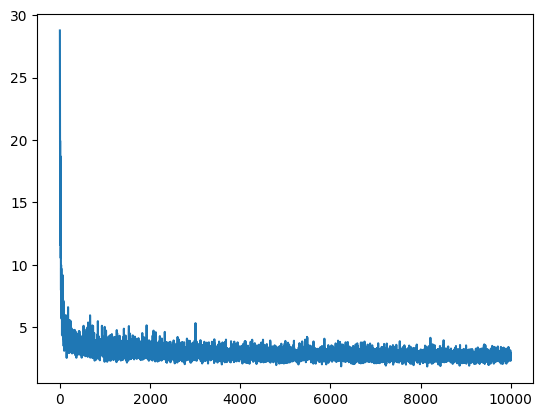

In [326]:
# check stats in graph
plt.plot(stepi, lossi)
plt.show()

In [328]:
# evaluate with dev set, neural network did not see Xdev samples during training
emb = C[Xtr] # (32, 3, 2)   # !! changed
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)   #!! changed
loss

tensor(2.5041, grad_fn=<NllLossBackward0>)

In [329]:
# evaluate with dev set, neural network did not see Xdev samples during training
emb = C[Xdev] # (32, 3, 2)   # !! changed
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)   #!! changed
loss

tensor(2.5195, grad_fn=<NllLossBackward0>)

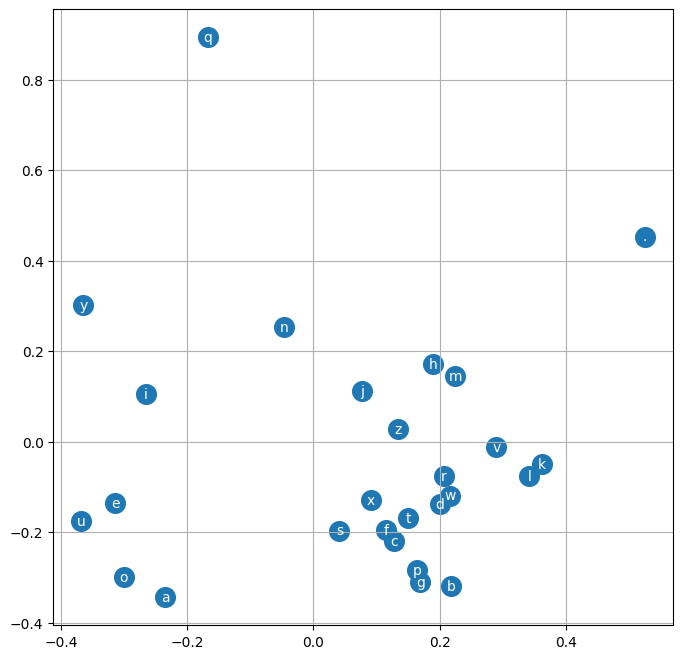

In [333]:
# another issue of underfitting, could be the 2 dimension of index tensor, too small
# we are not improving anymore, and may reach the bottleneck

# we want to visualize the embedding
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')
plt.show()   # because we only have 2 dimensions indexing tensor, we can see in x,y 
# interesting finding, the vowels a,e,i,o,u are clustered in left bottom corner
# kind of interchangable
# q, . (special char) are way out


In [337]:
# we will train use 10 dimensional embeddings
# repeat code
g = torch.Generator().manual_seed(42)   # for reproducibility
C = torch.randn((27, 10), generator=g)   # !! changed from 27 to 30, 2 to 10
W1 = torch.randn((30, 200), generator=g)  # hidden layer, !! changed 100 to 300
b1 = torch.randn(200, generator=g)       # hidden layer bias  !! also changed from 100 to 300
W2 = torch.randn((200, 27), generator=g)  # final layer  !! changed 
b2 = torch.randn(27, generator=g)         # final layer bias
parameters = [C, W1, b1, W2, b2]          # cluster all together to count paramters

print(sum(p.nelement() for p in parameters))  # number of parameters in total  !! changed from 3481 to 10281

11897


In [339]:
for p in parameters:
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

# only Xtrain
lri = []
lossi = []
stepi = []


In [340]:
for i in range(10000):   # run twice with lr = 0.1
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  # !! changed we may need to change batch size to bigger

    # forward pass 
    emb = C[Xtr[ix]]  # !! changed
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2   # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])   # !! changed
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1  # or 10**-1  , train twice first for 10000
    # lr = 0.01  # or 10**-1  , train last ending stage once with smaller lr , improve by using learning rate decay, a factor of 10
    
    for p in parameters:
        p.data += -lr * p.grad   # the p.grad from forward pass, p: tensors

    # track stats
    # lri.append(lr)    # not learning rate, but lre
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())


2.205228567123413


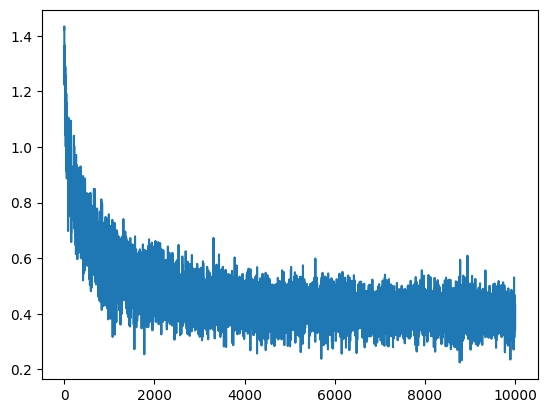

In [341]:
plt.plot(stepi, lossi)
plt.show()

In [342]:
# evaluate with dev set, neural network did not see Xdev samples during training
emb = C[Xtr] # (32, 3, 2)   # !! changed
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)   #!! changed
loss

tensor(2.5232, grad_fn=<NllLossBackward0>)

In [344]:
# evaluate with dev set, neural network did not see Xdev samples during training
emb = C[Xdev] # (32, 3, 2)   # !! changed
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)   #!! changed
loss

tensor(2.5471, grad_fn=<NllLossBackward0>)

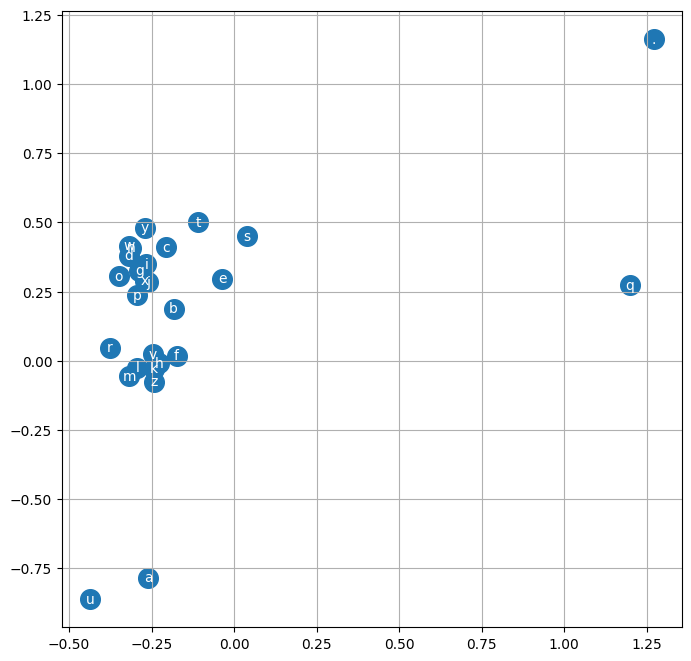

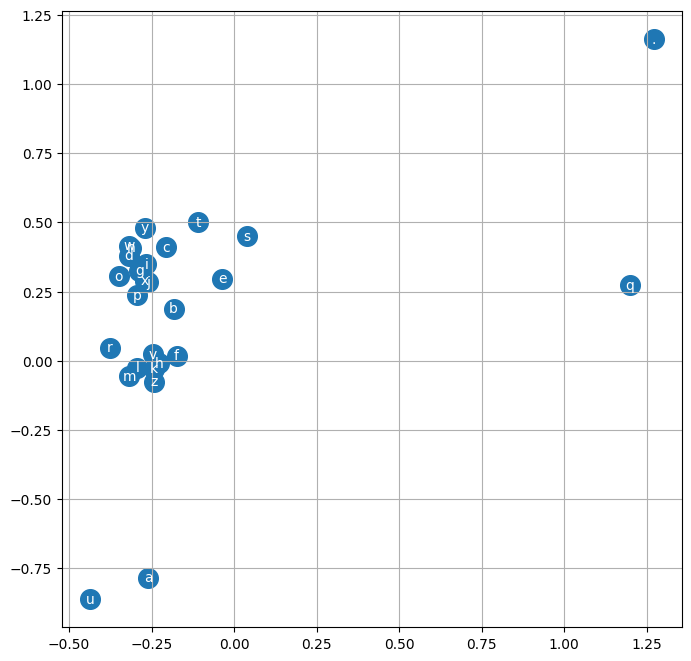

In [346]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()

In [347]:
# When you find dev validation is good, run test data once
# We can continue optimization
# We can play with the size of the neural net
# We can increase the number of words and characters, taking more characters as input
# increase the training steps to 200000
# change lr from 0.1, 0.01,
# tune a few knobs availabl to optimize the neural network training
# change the dimensionality of the embedding lookup table
# change the number of characters that are feeding in as an input as the context into this model
# change the optimization how long are we running
# what are learning rate, how does it change over time, how does it decay
# change the batch size, can achieve a much better convergence speed
# change training time to reach low loss

# worth read the paper 


In [353]:
# how to sample from the model
g = torch.Generator().manual_seed(42 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size   # initiaize with all ...
    while True:
        emb = C[torch.tensor([context])]   # using embedding table C, context size
                                            #(1, block_size, d), single example we are generating
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2    # projects to logits
        probs = F.softmax(logits, dim=1)   # exponentiates the logits and make them sum to one
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()  # sample to get out text
        context = context[1:] + [ix]    # shift context window
        out.append(ix)   # record it
        if ix == 0:   # until we reach 0, move to next for loop
            break
    print(''.join(itos[i] for i in out))  # decode integer to string, print out
# made progress, can still improve

elyan.
casiiah.
huy.
elia.
mla.
marman.
nacm.
tha.
julisla.
dnd.
laulri.
amari.
karli.
alen.
mha.
briencl.
joon.
mesk.
dymo.
jos.
